In [57]:
# Import Packages
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
import getpass
import mysql.connector
from sqlalchemy import create_engine

In [58]:
# Read in shark data
eat = pd.read_excel("SharkData.xlsx", sheet_name = 0)
targets = pd.read_excel("SharkData.xlsx", sheet_name = 1)
drops = pd.read_excel("SharkData.xlsx", sheet_name = 2)
other_factors = pd.read_excel("SharkData.xlsx", sheet_name = 3)

# Data Cleaning

In [59]:
# Clean eating dataset
eat = eat.iloc[1:,:-1]
eat.rename(columns = {"Unnamed: 14":'Etc. Comments', "Pieces Eaten": "Date", 'Total: ' : 'Total'}, inplace = True)

#get rid of null values at end of dataset
eat = eat.head(582)

# Change date to just date format, not datetime
eat['Date'] = pd.to_datetime(eat['Date']).dt.date


eat.tail()

,Date,Ross,Chandler,BT1,BT2,BT3,BT4,BT5,GR1,GR2,GR3,GR4,GR5,Total,Etc. Comments
578,2020-09-22,6.0,0.0,1.0,2.0,6.0,0.0,4.0,1.0,0.0,0.0,5.0,1.0,26.0,NaN
579,2020-09-24,0.0,9.0,0.0,7.0,5.0,5.0,7.0,0.0,1.0,2.0,2.0,6.0,44.0,NaN
580,2020-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,2.0,3.0,3.0,12.0,NaN
581,2020-09-27,5.0,6.0,3.0,6.0,4.0,6.0,3.0,NaN,NaN,NaN,NaN,NaN,33.0,NaN
582,2020-09-29,10.0,3.0,1.0,1.0,4.0,2.0,7.0,4.0,4.0,0.0,2.0,0.0,38.0,NaN


In [60]:
# Clean Drops Dataset
drops = drops.iloc[1:,:-1]
drops['Drops'] = pd.to_datetime(drops['Drops']).dt.date
drops.rename(columns = {"Drops" : "Date", "Total: ":"Total"}, inplace = True)
drops.tail()

,Date,Ross,Chandler,BT1,BT2,BT3,BT4,BT5,GR1,GR2,GR3,GR4,GR5,Total
578,2020-09-22,0.0,0.0,1.0,4.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,10.0
579,2020-09-24,0.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,7.0
580,2020-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0
581,2020-09-27,0.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,3.0
582,2020-09-29,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0


In [80]:
# Clean Targets Dataset
targets = targets.iloc[1:,:-1]
targets.rename(columns = {"Unnamed: 14":'Etc. Comments', "Targets": "Date", "Total: ": "Total"}, inplace = True)

#get rid of null values at end of dataset
targets = targets.head(582)

# Change date to just date format, not datetime
targets['Date'] = pd.to_datetime(targets['Date']).dt.date


targets.tail()

,Date,Ross,Chandler,BT1,BT2,BT3,BT4,BT5,GR1,GR2,...,GR4,GR5,Total,All_GR,All_BT,All_SS,male,female,Day_of_week,Month
578,2020-09-22,6.0,1.0,4.0,6.0,5.0,4.0,7.0,2.0,1.0,...,4.0,1.0,46.0,13.0,26.0,7.0,20.0,26.0,1,9
579,2020-09-24,8.0,18.0,2.0,9.0,10.0,10.0,11.0,5.0,6.0,...,7.0,9.0,98.0,30.0,42.0,26.0,44.0,54.0,3,9
580,2020-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,...,5.0,8.0,24.0,24.0,NaN,NaN,6.0,18.0,5,9
581,2020-09-27,10.0,19.0,9.0,10.0,8.0,16.0,3.0,NaN,NaN,...,NaN,NaN,75.0,NaN,46.0,29.0,41.0,34.0,6,9
582,2020-09-29,15.0,5.0,6.0,6.0,4.0,4.0,7.0,4.0,1.0,...,4.0,1.0,61.0,14.0,27.0,20.0,37.0,24.0,1,9


# Other Factors Data Cleaning and Dummy Variable Creation for Foods


In [62]:
dummy_factors = other_factors[['Date','Saury', 'Blue Runner',
                'Squid', 'Mackerel', 'Herring', 'Sardine',
                'Mazuri Vitamins', 'Garlic', 'Salmon', 'Bonito', 'Bluefish', 'Mahi',
                    'Goggle Eye', 'Humbolt Squid']]
dummy_factors['Date'] = pd.to_datetime(dummy_factors['Date'])
for i in dummy_factors:
    dummy_factors[i] = dummy_factors[i].fillna(0)
dummy_factors.head()

/home/stats/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/stats/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Date,Saury,Blue Runner,Squid,Mackerel,Herring,Sardine,Mazuri Vitamins,Garlic,Salmon,Bonito,Bluefish,Mahi,Goggle Eye,Humbolt Squid
0,2017-12-05,1.0,0.0,0.0,0.0,0.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-12-07,0.0,1.0,1.0,1.0,0.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-12-09,0.0,0.0,0.0,0.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-12-10,0.0,0.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-12-12,1.0,0.0,0.0,0.0,0.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Subset Creation

In [63]:
# All Sharks Subset
All_Sharks = eat[['Ross', 'Chandler','BT1','BT2','BT3','BT4','BT5','GR1','GR2','GR3','GR4', 'GR5','Total']]

# All SS Subset
All_SS = eat[['Ross', 'Chandler']]

# All BT Subset
All_BT = eat[['BT1', 'BT2', 'BT3', 'BT4', 'BT5']]

# All GR Subset
All_GR = eat[['GR1', 'GR2', 'GR3', 'GR4', 'GR5']]

# Male Subset
Male = eat[["BT1","BT5","GR1","Ross","Chandler"]]

# Female Subset
female = eat[["BT2","BT3","BT4","GR2","GR3","GR4","GR5"]]

# Append all subsets to original datasets
# eat dataset
eat["All_GR"] = eat['GR1'] + eat['GR2'] + eat['GR3'] + eat['GR4'] + eat['GR5']
eat["All_BT"] = eat['BT1'] + eat['BT2'] + eat['BT3'] + eat['BT4'] + eat['BT5']
eat["All_SS"] = eat['Ross'] + eat['Chandler']
eat["male"] = eat[["BT1","BT5","GR1","Ross","Chandler"]].sum(axis = 1)
eat["female"] = eat[["BT2","BT3","BT4","GR2","GR3","GR4","GR5"]].sum(axis = 1)

# drop dataset
drops["All_GR"] = drops['GR1'] + drops['GR2'] + drops['GR3'] + drops['GR4'] + drops['GR5']
drops["All_BT"] = drops['BT1'] + drops['BT2'] + drops['BT3'] + drops['BT4'] + drops['BT5']
drops["All_SS"] = drops['Ross'] + drops['Chandler']
drops["male"] = drops[["BT1","BT5","GR1","Ross","Chandler"]].sum(axis = 1)
drops["female"] = drops[["BT2","BT3","BT4","GR2","GR3","GR4","GR5"]].sum(axis = 1)

# target dataset
targets["All_GR"] = targets['GR1'] + targets['GR2'] + targets['GR3'] + targets['GR4'] + targets['GR5']
targets["All_BT"] = targets['BT1'] + targets['BT2'] + targets['BT3'] + targets['BT4'] + targets['BT5']
targets["All_SS"] = targets['Ross'] + targets['Chandler']
targets["male"] = targets[["BT1","BT5","GR1","Ross","Chandler"]].sum(axis = 1)
targets["female"] = targets[["BT2","BT3","BT4","GR2","GR3","GR4","GR5"]].sum(axis = 1)


# Create Tables for Poisson Regression Time Series For Pieces Eaten For All Sharks

In [64]:
# create additional time variables for eating
eat['Date'] = pd.to_datetime(eat['Date'])
eat['Day_of_week'] = pd.to_datetime(eat['Date']).dt.dayofweek
eat['Month'] = pd.to_datetime(eat['Date']).dt.month
eat['Day'] = pd.to_datetime(eat['Date']).dt.day
eat_table1 = eat[['Total','Date', 'Day', 'Day_of_week', 'Month']]

In [66]:
# Create training and testing datasets
mask = np.random.rand(len(eat_table1)) < 0.8
eat_train = eat_table1[mask]
eat_test = eat_table1[~mask]
print('Training data set length='+str(len(eat_train)))
print('Testing data set length='+str(len(eat_test)))

Training data set length=467
Testing data set length=115


In [67]:
# setup Poisson regression expression
expr = """Total ~ Day_of_week + Month + Day"""

In [68]:
y_train, X_train = dmatrices(expr, eat_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, eat_test, return_type='dataframe')

In [69]:
# Fit model and print results of model
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                  466
Model:                            GLM   Df Residuals:                      462
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2020.2
Date:                Wed, 02 Dec 2020   Deviance:                       1858.0
Time:                        17:38:05   Pearson chi2:                 1.76e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.3902      0.033    102.339      

In [70]:
# Create prediction of number of fish eaten by All Sharks
poisson_predictions = poisson_training_results.get_prediction(X_test)
 
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

          mean   mean_se  mean_ci_lower  mean_ci_upper
4    16.573421  0.419617      15.771059      17.416603
5    29.244552  0.687937      27.926831      30.624450
6    23.119091  0.464665      22.226068      24.047994
13   28.115089  0.738238      26.704770      29.599888
16   15.622620  0.481674      14.706515      16.595792
..         ...       ...            ...            ...
563  21.315470  0.376964      20.589292      22.067259
571  22.610696  0.328445      21.976033      23.263688
572  17.874739  0.293198      17.309220      18.458734
578  27.496831  0.524518      26.487774      28.544327
581  15.279075  0.363875      14.582282      16.009163

[115 rows x 4 columns]


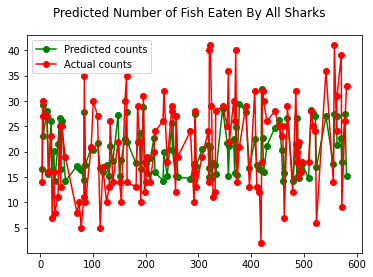

In [71]:
# Create graph of predicted counts alongside actual counts

predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['Total']
 
fig = plt.figure()
fig.suptitle('Predicted Number of Fish Eaten By All Sharks')
 
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
 
plt.legend(handles=[predicted, actual])
 
plt.show()

# Poisson Regression for Number of Drops for All Sharks

In [72]:
# create additional time variables for dropping
drops['Date'] = pd.to_datetime(drops['Date'])
drops['Day_of_week'] = pd.to_datetime(drops['Date']).dt.dayofweek
drops['Month'] = pd.to_datetime(drops['Date']).dt.month
drops['Day'] = pd.to_datetime(drops['Date']).dt.day
drops_table = drops[['Total','Date', 'Day', 'Day_of_week', 'Month']]

In [73]:
# Create training and testing datasets
mask = np.random.rand(len(drops_table)) < 0.8
drops_train = drops_table[mask]
drops_test = drops_table[~mask]
print('Training data set length='+str(len(drops_train)))
print('Testing data set length='+str(len(drops_test)))

Training data set length=474
Testing data set length=108


In [74]:
# setup Poisson regression expression
expr = """Total ~ Day_of_week + Month + Day"""

In [75]:
y_train, X_train = dmatrices(expr, drops_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, drops_test, return_type='dataframe')

In [76]:
# Fit model and print results of model
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                  474
Model:                            GLM   Df Residuals:                      470
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1239.8
Date:                Wed, 02 Dec 2020   Deviance:                       1250.4
Time:                        17:38:26   Pearson chi2:                 1.23e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.6536      0.079     20.912      

In [78]:
# Create prediction of number of fish dropped by All Sharks
poisson_predictions = poisson_training_results.get_prediction(X_test)
 
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

         mean   mean_se  mean_ci_lower  mean_ci_upper
3    2.835060  0.160040       2.538117       3.166744
7    2.839188  0.150413       2.559174       3.149840
10   3.485671  0.173689       3.161343       3.843272
15   2.847461  0.187971       2.501883       3.240773
21   4.687246  0.263824       4.197662       5.233931
..        ...       ...            ...            ...
549  2.645732  0.154981       2.358764       2.967613
551  3.596403  0.141975       3.328630       3.885717
577  2.632914  0.127314       2.394842       2.894652
578  4.387523  0.193894       4.023491       4.784492
580  2.919434  0.140000       2.657540       3.207137

[108 rows x 4 columns]


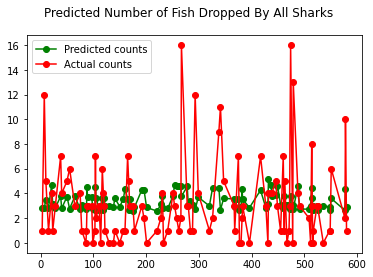

In [79]:
# Create graph of predicted counts alongside actual counts

predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['Total']
 
fig = plt.figure()
fig.suptitle('Predicted Number of Fish Dropped By All Sharks')
 
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
 
plt.legend(handles=[predicted, actual])
 
plt.show()

# Poisson Regression for Number of Targets for All Sharks

In [81]:
# create additional time variables for Targeting
targets['Date'] = pd.to_datetime(targets['Date'])
targets['Day_of_week'] = pd.to_datetime(targets['Date']).dt.dayofweek
targets['Month'] = pd.to_datetime(targets['Date']).dt.month
targets['Day'] = pd.to_datetime(targets['Date']).dt.day
targets_table = targets[['Total','Date', 'Day', 'Day_of_week', 'Month']]

In [82]:
# Create training and testing datasets
mask = np.random.rand(len(targets_table)) < 0.8
targets_train = targets_table[mask]
targets_test = targets_table[~mask]
print('Training data set length='+str(len(targets_train)))
print('Testing data set length='+str(len(targets_test)))

Training data set length=476
Testing data set length=105


In [83]:
# setup Poisson regression expression
expr = """Total ~ Day_of_week + Month + Day"""

In [85]:
y_train, X_train = dmatrices(expr, targets_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, targets_test, return_type='dataframe')

In [86]:
# Fit model and print results of model
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                  476
Model:                            GLM   Df Residuals:                      472
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4853.9
Date:                Wed, 02 Dec 2020   Deviance:                       7012.7
Time:                        17:44:25   Pearson chi2:                 7.01e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.2758      0.020    214.063      

In [87]:
# Create prediction of number of fish dropped by All Sharks
poisson_predictions = poisson_training_results.get_prediction(X_test)
 
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

          mean   mean_se  mean_ci_lower  mean_ci_upper
7    48.761041  0.639339      47.523923      50.030363
9    63.248834  0.906472      61.496902      65.050676
21   67.015601  0.963177      65.154150      68.930235
23   51.640182  0.652052      50.377867      52.934127
28   48.359536  0.708020      46.991563      49.767333
..         ...       ...            ...            ...
550  64.643809  0.855016      62.989543      66.341520
560  49.764723  0.477222      48.838120      50.708905
569  46.438084  0.618637      45.241271      47.666557
571  56.436076  0.511073      55.443228      57.446703
577  46.393495  0.543490      45.340410      47.471040

[105 rows x 4 columns]


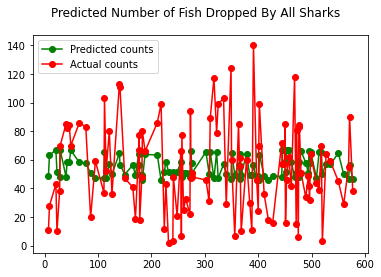

In [88]:
# Create graph of predicted counts alongside actual counts

predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['Total']
 
fig = plt.figure()
fig.suptitle('Predicted Number of Fish Dropped By All Sharks')
 
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
 
plt.legend(handles=[predicted, actual])
 
plt.show()